# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

You should produce a Jupyter notebook in answer to this assignment.
**You need to submit this notebook electronically as described below.**

Place your notebook in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 4 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers. **You are welcome to split your answer into multiple cells with intermediate printing.**

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [2]:
from __future__ import print_function, division
%matplotlib inline

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.cluster import KMeans
import collections
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB

## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [5]:
print (pd.Series(y, dtype="category").head(10))
print ('X contains: {0} instances. {1} attributes'.format(np.shape(X)[0],np.shape(X)[1]))
X.describe()



0          rec.sport.baseball
1          rec.sport.baseball
2            rec.sport.hockey
3    comp.sys.ibm.pc.hardware
4          rec.sport.baseball
5                 alt.atheism
6       comp.sys.mac.hardware
7            rec.sport.hockey
8                 alt.atheism
9          rec.sport.baseball
dtype: category
Categories (5, object): [alt.atheism, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, rec.sport.baseball, rec.sport.hockey]
X contains: 2845 instances. 1000 attributes


,abc,ability,able,ac,accept,access,according,acquired,actually,adaptec,...,written,wrong,yankees,yeah,year,years,yes,york,young,zone
count,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,...,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,0.002436,0.002144,0.006710,0.001454,0.002285,0.003945,0.003125,0.000920,0.008367,0.001806,...,0.002612,0.006811,0.002467,0.003558,0.016914,0.008786,0.006380,0.002770,0.003283,0.001625
std,0.030224,0.020707,0.034655,0.023100,0.021627,0.030010,0.026981,0.016265,0.043932,0.025845,...,0.026987,0.039179,0.032725,0.031204,0.061089,0.039306,0.037314,0.025372,0.030906,0.022160
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.723914,0.420916,0.431380,0.519765,0.443354,0.663808,0.572124,0.412727,1.000000,0.578282,...,0.723081,0.568146,0.878185,0.693531,0.650649,0.455493,0.646447,0.572455,0.703771,0.605576


Y contains 2845 objects of only 5 categories (5 newsgroups), those are the true labels of the documents. X contains 2845 instances and 1000 attributes from the Newsgroup training dataset and represent the different number of words contained in the different documents from the newsgroups and their value ranks from 0 to 1, which is the weitght -or importance- each word has for classifying the document. The task, I suppose, will be to predict the output class -within the 5 previously mentioned - from an input document by the number of words (type of words) in the document. 

### ========== Question 1.2 ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [6]:
KC = KMeans(n_clusters=5,random_state=1670329).fit(X)

### ========== Question 1.3 ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [7]:
Dist = []
Xmean = X.mean()
for i in range (X.shape[0]):
    Dist.append(np.sqrt(sum([(x-mean)**2 for x,mean in zip(X.iloc[i],Xmean)])))
print ('AVERAGE DISTANCE OF A DATA POINT FROM THE CENTRE:', np.mean(Dist))
print ('INERTIA OF THE MODEL {0}:'.format(KC.inertia_))
print ('ADJUSTED RAND INDEX: {0}'.format(adjusted_rand_score(y, KC.predict(X))))


AVERAGE DISTANCE OF A DATA POINT FROM THE CENTRE: 0.954581397358
INERTIA OF THE MODEL 2593.16421136:
ADJUSTED RAND INDEX: 0.233620865738


### ========== Question 1.4 ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [8]:
true = collections.Counter(y)
predicted=collections.Counter(KC.labels_)
Tvalue = 0
for element,value in zip(true.iterkeys(),true.itervalues()):
    print ('THE LABEL: {0} HAS {1} DATAPOINTS'.format(element, value))
    Tvalue+=value
print ('--- TOTAL NUMBER OF DATAPOINTS PROCESSED: {0} ---'.format(Tvalue))
Tvalue=0
print ('\n'+100*'-'+'\n')
for element,value in zip(predicted.iterkeys(),predicted.itervalues()):
    print ('LABEL: {0} HAS {1} DATAPOINTS'.format(element, value))
    Tvalue+=value
print ('--- TOTAL NUMBER OF DATAPOINTS PROCESSED: {0} ---'.format(Tvalue))
    



THE LABEL: rec.sport.baseball HAS 597 DATAPOINTS
THE LABEL: alt.atheism HAS 480 DATAPOINTS
THE LABEL: comp.sys.mac.hardware HAS 578 DATAPOINTS
THE LABEL: comp.sys.ibm.pc.hardware HAS 590 DATAPOINTS
THE LABEL: rec.sport.hockey HAS 600 DATAPOINTS
--- TOTAL NUMBER OF DATAPOINTS PROCESSED: 2845 ---

----------------------------------------------------------------------------------------------------

LABEL: 0 HAS 343 DATAPOINTS
LABEL: 1 HAS 1015 DATAPOINTS
LABEL: 2 HAS 614 DATAPOINTS
LABEL: 3 HAS 222 DATAPOINTS
LABEL: 4 HAS 651 DATAPOINTS
--- TOTAL NUMBER OF DATAPOINTS PROCESSED: 2845 ---


There's a big difference on how the points are distributed in both sets. On the true labels, it seems to be rather an uniform distribution. On the predicted one the distribution of the labels is quite uneven. This could mean that the model if not performing good with the number of components chosen.

### ========== Question 1.5 ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [9]:
def distances(i,j):
    distance = np.sqrt((np.mean(KC.cluster_centers_[i])-np.mean(KC.cluster_centers_[j]))**2)
    print ('Distance between centre {0} and {1} is: {2}'.format(i,j,distance))
    return (distance)

DistanceMatrix =[]       
for i in range (0,len(KC.cluster_centers_)):
    for j in range (0,len(KC.cluster_centers_)):
        distance = distances(i,j)
        DistanceMatrix.append(distance)
DistanceMatrix = np.array(DistanceMatrix)
DistanceMatrix = DistanceMatrix.reshape((len(KC.cluster_centers_),len(KC.cluster_centers_)))


Distance between centre 0 and 0 is: 0.0
Distance between centre 0 and 1 is: 0.00177658234285
Distance between centre 0 and 2 is: 0.000405003134505
Distance between centre 0 and 3 is: 4.7769738339e-05
Distance between centre 0 and 4 is: 0.00028523623253
Distance between centre 1 and 0 is: 0.00177658234285
Distance between centre 1 and 1 is: 0.0
Distance between centre 1 and 2 is: 0.00218158547735
Distance between centre 1 and 3 is: 0.00172881260451
Distance between centre 1 and 4 is: 0.00149134611032
Distance between centre 2 and 0 is: 0.000405003134505
Distance between centre 2 and 1 is: 0.00218158547735
Distance between centre 2 and 2 is: 0.0
Distance between centre 2 and 3 is: 0.000452772872844
Distance between centre 2 and 4 is: 0.000690239367034
Distance between centre 3 and 0 is: 4.7769738339e-05
Distance between centre 3 and 1 is: 0.00172881260451
Distance between centre 3 and 2 is: 0.000452772872844
Distance between centre 3 and 3 is: 0.0
Distance between centre 3 and 4 is: 0.00

### ========== Question 1.6 ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

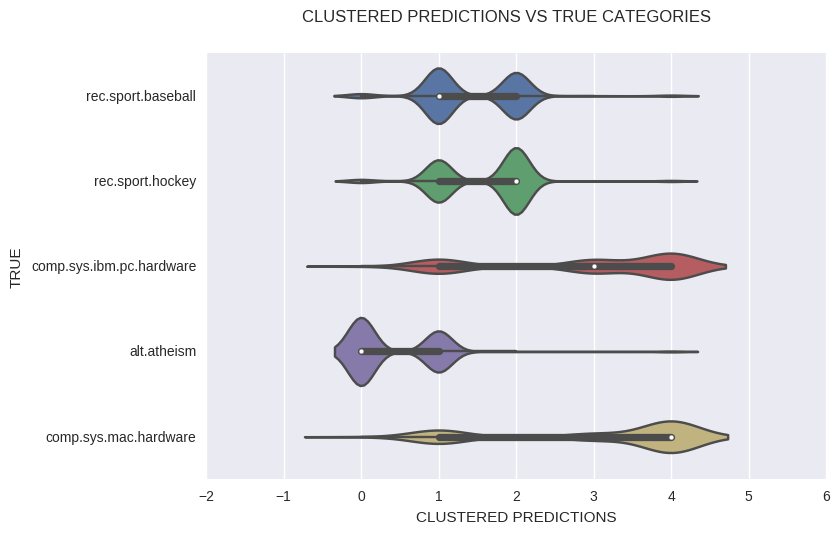

In [10]:
sns.violinplot(KC.labels_, y)
plt.xlabel('CLUSTERED PREDICTIONS')
plt.ylabel('TRUE')
plt.suptitle('CLUSTERED PREDICTIONS VS TRUE CATEGORIES')
sns.set(style="ticks", palette="colorblind")
plt.show()

For the predicted cluster 0 there is no clear to which class it might belong to, as there are more than 2 classes where the correlation seems quite large. For cluster 1, seems like comp.sys.mac.hardware is the label with the larger correlation. Undoubtely cluster 2 belongs to alt.altheism and the rest of the clusters might not be as well defined either. Again, the performance of the clustering does not seem to be good at all as the clustering is not well defined.

### ========== Question 1.7 ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

In [11]:
n_components = [1,2,3,5,10,20,50,100,500,1000]
results =[]
for component in n_components:
    PC = PCA(n_components=component).fit_transform(X)
    KC2 = KC.fit(PC)
    results.append((component, KC2.inertia_,adjusted_rand_score(y, KC2.labels_)))

In [12]:
print ('COMPONENTS\t  INERTIA\t\t  RAND_SCORE')
for element in results:
    n_component, inertia, randScore = element
    print ('{0}\t\t{1}\t\t{2}'.format(n_component,inertia,randScore))

COMPONENTS	  INERTIA		  RAND_SCORE
1		2.82137445939		0.208847245088
2		10.5922907745		0.268079336483
3		20.4237163683		0.239479218068
5		49.8677216993		0.225455282073
10		118.179364011		0.217415175506
20		231.922834247		0.213414952579
50		494.184533491		0.123732039712
100		820.244158446		0.212457247568
500		2143.61808514		0.213545642383
1000		2593.316745		0.263537404171


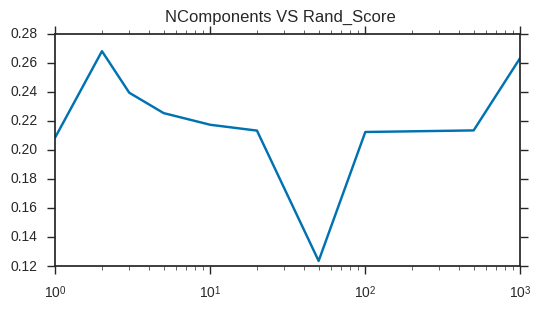

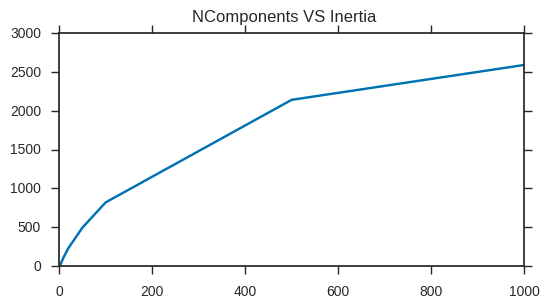

In [13]:
#PLOTTING RANDSCORE VS NCOMPONENTS
plt.figure(figsize=(6,3))
plt.plot([component[0] for component in results],[rand[2] for rand in results])
plt.xscale('log')
plt.suptitle('NComponents VS Rand_Score')
plt.show()
#PLOTTING NCOMPONENTS VS INERTIA
plt.figure(figsize=(6,3))
plt.plot([component[0] for component in results],[rand[1] for rand in results])
plt.suptitle('NComponents VS Inertia')
plt.show()

### ========== Question 1.8 ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

In [14]:
X_2d = PCA(n_components=2).fit_transform(X)
kmeans_pca = KC.fit(X_2d)
print ('ADJUSTED RAND SCORE: {0}'.format(adjusted_rand_score(y, kmeans_pca.labels_)))

ADJUSTED RAND SCORE: 0.268079336483


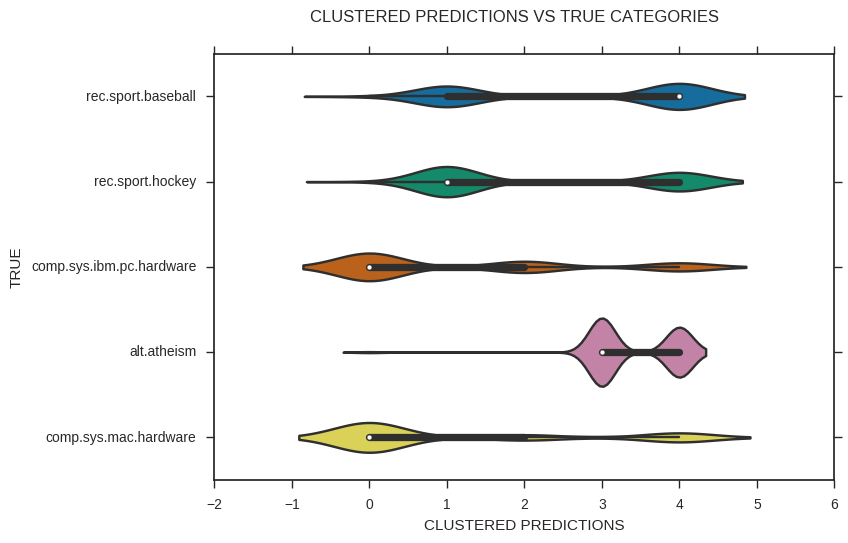

In [15]:
sns.violinplot(kmeans_pca.labels_, y)
plt.xlabel('CLUSTERED PREDICTIONS')
plt.ylabel('TRUE')
plt.suptitle('CLUSTERED PREDICTIONS VS TRUE CATEGORIES')
sns.set(style="ticks", palette="colorblind")
plt.show()

There seems to be a better definition of the clusters with respect to the true labels. Predicted label 4 is more defined to be alt.altheism. But there are still some clusters that are not so well defined, E.g. 1,2,3.

### ========== Question 1.9 ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [16]:
labels=['comp.sys.mac.hardware', 'rec.sport.hockey','rec.sport.baseball', 'comp.sys.ibm.pc.hardware', 'alt.atheism']
originalLabels = ['alt.atheism','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.sport.baseball','rec.sport.hockey']
labels_interp = kmeans_pca.labels_
new_labels =[]
for label in enumerate(labels_interp):
    new_labels.append(labels[int(label[1])])
print ('ASSIGNED CATTEGORIES TO CLUSTERS\n')
print ('ORIGINAL\t\t     CLUSTER\t\tNEW.CAT')
for i in range(5):
    print ('{0}\t\t\t{1}\t\t{2}'.format(originalLabels[i],i,labels[i]))


ASSIGNED CATTEGORIES TO CLUSTERS

ORIGINAL		     CLUSTER		NEW.CAT
alt.atheism			0		comp.sys.mac.hardware
comp.sys.ibm.pc.hardware			1		rec.sport.hockey
comp.sys.mac.hardware			2		rec.sport.baseball
rec.sport.baseball			3		comp.sys.ibm.pc.hardware
rec.sport.hockey			4		alt.atheism


In [17]:
true = collections.Counter(y)
predicted=collections.Counter(new_labels)
Tvalue = 0
for element,value in zip(true.iterkeys(),true.itervalues()):
    print ('THE LABEL: {0} HAS {1} DATAPOINTS'.format(element, value))
    Tvalue+=value
print ('--- TOTAL NUMBER OF DATAPOINTS PROCESSED: {0} ---'.format(Tvalue))
Tvalue=0
print ('\n'+100*'-'+'\n')
for element,value in zip(predicted.iterkeys(),predicted.itervalues()):
    print ('LABEL: {0} HAS {1} DATAPOINTS'.format(element, value))
    Tvalue+=value
print ('--- TOTAL NUMBER OF DATAPOINTS PROCESSED: {0} ---'.format(Tvalue))
    


THE LABEL: rec.sport.baseball HAS 597 DATAPOINTS
THE LABEL: alt.atheism HAS 480 DATAPOINTS
THE LABEL: comp.sys.mac.hardware HAS 578 DATAPOINTS
THE LABEL: comp.sys.ibm.pc.hardware HAS 590 DATAPOINTS
THE LABEL: rec.sport.hockey HAS 600 DATAPOINTS
--- TOTAL NUMBER OF DATAPOINTS PROCESSED: 2845 ---

----------------------------------------------------------------------------------------------------

LABEL: rec.sport.baseball HAS 211 DATAPOINTS
LABEL: comp.sys.mac.hardware HAS 752 DATAPOINTS
LABEL: rec.sport.hockey HAS 620 DATAPOINTS
LABEL: comp.sys.ibm.pc.hardware HAS 296 DATAPOINTS
LABEL: alt.atheism HAS 966 DATAPOINTS
--- TOTAL NUMBER OF DATAPOINTS PROCESSED: 2845 ---


### ========== Question 1.10 ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

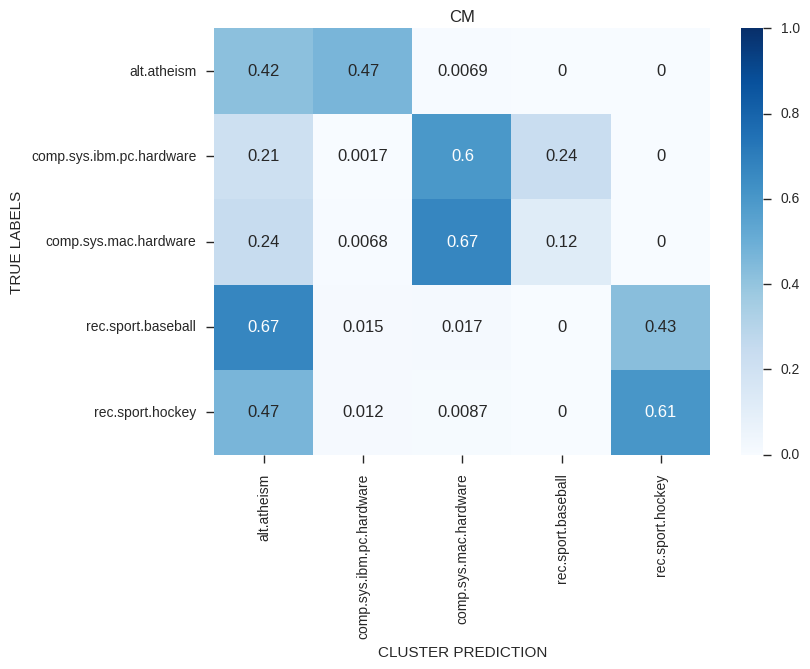

In [18]:
cm = confusion_matrix(y,new_labels)
cm = cm / cm.sum(1)
sns.heatmap(cm,xticklabels=originalLabels,cmap=plt.cm.Blues, yticklabels=originalLabels,annot=True,vmin=0,vmax=1,)
plt.title('CM')
plt.xlabel('CLUSTER PREDICTION')
plt.ylabel('TRUE LABELS')
plt.show()

### ========== Question 1.11 ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

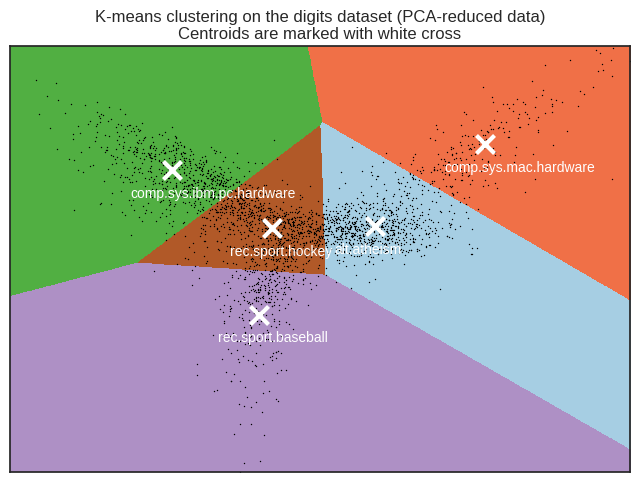

In [22]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .0005     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_2d[:, 0].min(), X_2d[:, 0].max()
y_min, y_max = X_2d[:, 1].min(), X_2d[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(X_2d[:, 0], X_2d[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

for centroid, name in zip(centroids, originalLabels):
    plt.annotate(name,xy=(centroid[0], centroid[1]), color='white', fontsize=10,
         xytext=(centroid[0]-.05, centroid[1]-.05)
    )

plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### ========== Question 1.12  ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.2 (fitting k-means) do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

#### ANSWERS 

1. Yes, but not from default. From default the algorithm spreads points randomly and clusters the points around them. 
2. No, it would be too computationally expensive.
3. Another method would be to fit models inside the data and move the models accordingly through the data until convergence. This could be potentially expensive.


## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. Print the max/min values for each dimension
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

#### 1. Use the pandas describe method on the data to get a feel for the range of each dimension 

In [24]:
digitsData = pd.DataFrame(digits.data)
digitsData.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


#### 2. Print the max/min values for each dimension  

In [25]:
digitsData.describe().T[['min','max']].T

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,8.0,16.0,16.0,16.0,16.0,16.0,15.0,2.0,16.0,...,16.0,13.0,1.0,9.0,16.0,16.0,16.0,16.0,16.0,16.0


#### 3. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use sns.heatmap()) to show you which dimensions vary the most. 

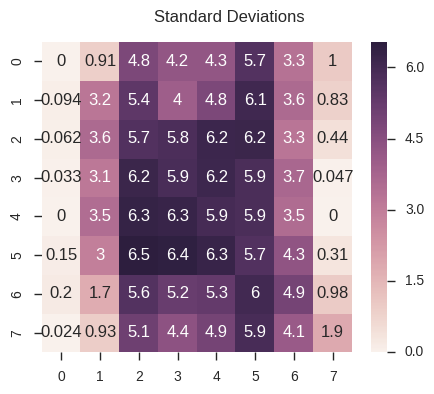

In [26]:
SD = digitsData.describe().T[['std']]
SD = np.array(SD).reshape((8,8))
plt.figure(figsize=(5,4))
plt.suptitle('Standard Deviations')
sns.heatmap(SD, annot=True)
plt.show()

#### 4. For a bonus mark, produce a plot like this for each digit. Hint: you can use .groupby(digits.target) before calling .describe(). 

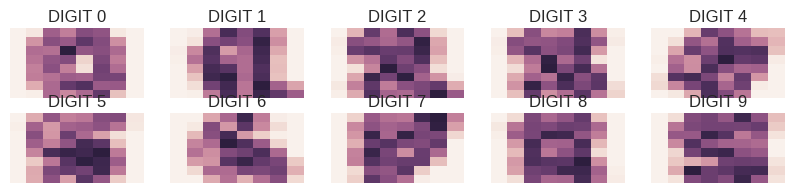

In [27]:
digitFigures = digitsData.groupby(digits.target).std()
plt.figure(figsize=(10,2))
for i in range (0,10):
    plt.subplot(2,5,i+1)
    sns.heatmap(digitFigures.iloc[i].reshape(8,8), cbar=False).set_title('DIGIT {0}'.format(str(i)))
    plt.xticks([''])
    plt.yticks([''])
plt.show()

#### 5. Use sns.heatmap() to plot the first 9 digits in the dataset

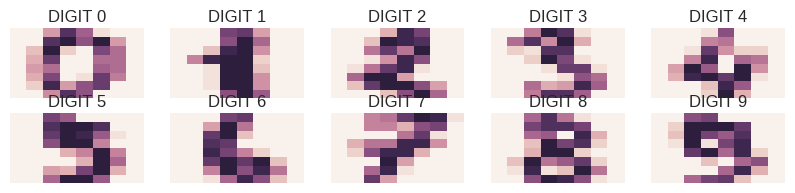

In [28]:
plt.figure(figsize=(10,2))
for i in range (0,10):
    plt.subplot(2,5,i+1)
    sns.heatmap(digitsData.iloc[i].reshape(8,8), cbar=False).set_title('DIGIT {0}'.format(str(i)))
    plt.xticks([''])
    plt.yticks([''])
plt.show()

Probably not. Like in the examples of Eigenfaces on the lecture videos, many of the pixels are not occupied (just in the last digits the first column is empty on all of the digits). Hence there is no case to deal with many dimension if not all of them are helpful.

### ========== Question 2.2 ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

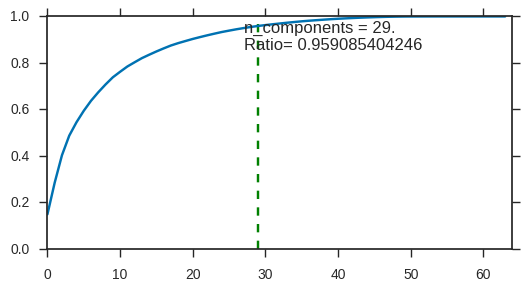

In [29]:
PC = PCA(n_components=digits.data.shape[1]).fit(digitsData)
plt.figure(figsize=((6,3)))
ratio = PC.explained_variance_ratio_.cumsum().tolist()
plt.xlim(0,64)
plt.ylim(0,1)
threshold = 0.95
Vlimit = 0
for element in enumerate(ratio):
    if (element[1] >= threshold and Vlimit==0): Vlimit = element[0]+1
plt.vlines(Vlimit,0,1,colors='g', linestyles='dashed')
plt.annotate('n_components = {0}.\nRatio= {1}'.format(Vlimit, ratio[Vlimit]),xy=(Vlimit, ratio[Vlimit]),
     xytext=(Vlimit-2, ratio[Vlimit]-.1))
plt.plot(ratio)
plt.show()


Applying the knowledge of the PCA lectures, we can see in the graph that 95.90% of the features can be described with only 29 components (out of the 64). PCA is a powerful method to capture the most of the features in a much lower dimensionality, in this case, with the 45.31% of the dimensions. This saves computational resources providing the same features, as for example, if we wanted then process the MNIST data with any other Machine Learning method for classification. 

### ========== Question 2.3 ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

#### You will find the eigenvectors stored within pca.components_. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs)

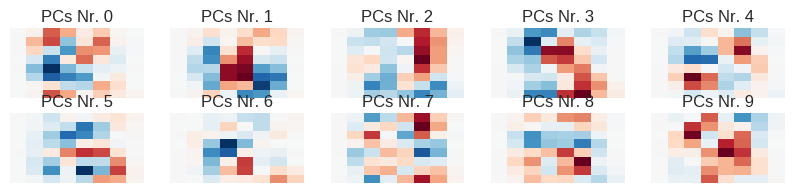

In [30]:
plt.figure(figsize=(10,2))
for i in range (0,10):
    plt.subplot(2,5,i+1)
    sns.heatmap(PC.components_[i].reshape(8,8), cbar=False).set_title('PCs Nr. {0}'.format(str(i)))
    plt.xticks([''])
    plt.yticks([''])
plt.show()


####  Below, plot pca.mean_. 

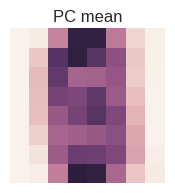

In [31]:
plt.figure(figsize=(2,2))
sns.heatmap(PC.mean_.reshape(8,8), cbar=False).set_title('PC mean'.format(str(i)))
plt.xticks([''])
plt.yticks([''])
plt.show()

### ========== Question 2.4 ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

In [32]:
DigitsPCA = [PC.transform(digits.data[Vlimit,:].reshape(1, -1)).flatten() for Vlimit in range(len(digits.data))]
DigitsPCA = pd.DataFrame(DigitsPCA)

#### The original digit 

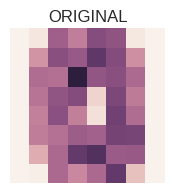

In [33]:
plt.figure(figsize=(2,2))
sns.heatmap(digitFigures.iloc[0].reshape(8,8), cbar=False).set_title('ORIGINAL'.format(str(i)))
plt.xticks([''])
plt.yticks([''])
plt.show()

#### AS IT WILL BE A REPETITIVE TASK, I CREATE A FUNCTION THAT TAKES THE NUMBER OF PC AND THE ID OF THE NUMBER AND PLOTS IT 

In [34]:
def plotNComponents(NPC, digit):
    plt.figure(figsize=(2,2))
    MeanDigit = PC.mean_.copy().flatten()
    image=[]
    NumberOfPC = 1
    for i in range (0,NPC):
        image= DigitsPCA.iloc[digit][i]*PC.components_[i]
        MeanDigit+=image
    sns.heatmap(MeanDigit.reshape(8,8), cbar=False).set_title('nComp: {0}. Var {1:.2f}%. Coef {2}'.format(str(NPC), ratio[i]*100, int(round(DigitsPCA.iloc[digit][i],0))), fontsize=10)
    plt.xticks([''])
    plt.xticks([''])
    plt.yticks([''])
    plt.show()

#### The digit reconstructed using 1 principal component

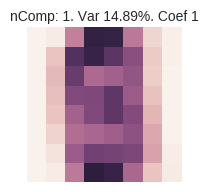

In [35]:
plotNComponents(1,0)

#### The digit reconstructed using 2 principal components

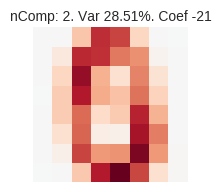

In [36]:
plotNComponents(2,0)

##### The digit reconstructed using 5 principal components

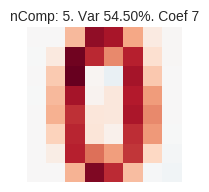

In [37]:
plotNComponents(5,0)

The digit is now clear for the human eye. It is amazing how using only 5 PC the data can be reconstructed. After using only 5 PC, I suppose any Machine Learning algorithm may be capable of doing a fair job recognizing the data.

### ========== Question 2.5 ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved but the other did not!

In [38]:
kfFolds = 5
kf= KFold(n=digitsData.shape[0], n_folds=kfFolds, shuffle=True, random_state=0)

#### Building a function that will go through the Kfolds  and report the result

In [39]:
def train(model, modelname, vector, target):
    scores=[]
    for train,test in kf:
            model.fit(vector[train],target[train])
            scores.append(model.score(vector[test],target[test]))
    print ('{0} achieved an score of: {1}'.format(modelname, np.mean(scores)))
    return (np.mean(scores))

#### SVC with a linear kernel, no shrinking, and a random_state on digit data 

In [40]:
SVScore = train(SVC(kernel='linear', random_state=0), 'SVC', digitsData.iloc, digits.target)

SVC achieved an score of: 0.984422779325


#### SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)

In [41]:
SV2Score = train(SVC(kernel='linear', random_state=0), 'SVC_PCA', DigitsPCA.iloc, digits.target)

SVC_PCA achieved an score of: 0.984422779325


#### Gaussian Naive Bayes Classifier on digit data

In [42]:
NBScore = train(GaussianNB(), 'NB',digitsData.iloc, digits.target)

NB achieved an score of: 0.833611884865


#### Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

In [43]:
NB2Score = train(GaussianNB(), 'NB_PCA', DigitsPCA.iloc, digits.target)

NB_PCA achieved an score of: 0.88872175797


In [44]:
Scores = [SVScore, SV2Score, NBScore, NB2Score]
Names = ['SVC digit data', 'SVC PCA digit data', 'Gaussian NB digit data', 'Gaussian NB PCA digit data']

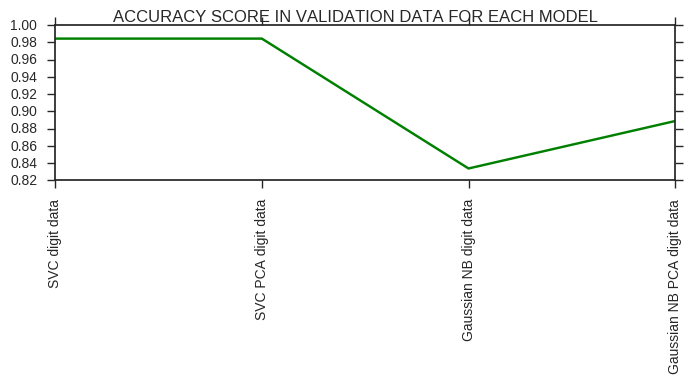

In [46]:
plt.figure(figsize=(8,2))
plt.plot(Scores, color = 'g')
plt.xticks(range(len(Scores)),Names, rotation='vertical')
plt.suptitle('ACCURACY SCORE IN VALIDATION DATA FOR EACH MODEL')
plt.show()

From the lectures we know that PCA assumes independence (hence its performance with NB), therefore NB does a good job in classifing the data but SVM does not do this asusmption and it's accuracy can be affected by the data independence.